# MisGAN: Learning from Incomplete Data with GANs

[Generative adversarial networks](https://arxiv.org/abs/1406.2661) (GANs)
provide a powerful modeling framework for learning complex
high-dimensional distributions.
Training GANs normally requires access to a large collection of
fully-observed data. However, it is not always possible to obtain a
large amount of fully-observed data. Missing data is well-known to be
prevalent in many real-world application domains where different data
cases might have different missing entries. This arbitrary missingness
poses a significant challenge to many existing machine learning models.

In this notebook, we present a quick introduction to
[MisGAN](https://openreview.net/forum?id=S1lDV3RcKm&noteId=S1lDV3RcKm),
a GAN-based framework for learning from incomplete data.
We demonstrate how to implement MisGAN in [PyTorch](https://pytorch.org/)
and run it on a modified MNIST dataset where the images are partially-observed.

**Note:** This notebook has been tested with PyTorch 1.6.0.

## Missing data

To understand the design of MisGAN, we first talk about how to formally
model missing data.
The generative process for incompletely observed
data can be described below where $\mathbf{x}\in\mathbb{R}^n$
is a complete data vector and $\mathbf{m}\in\{0,1\}^n$
is a binary mask that determines which entries in $\mathbf{x}$ to reveal:

$$
\begin{split}
  \mathbf{x}&\sim p_\theta(\mathbf{x}), \\
  \quad\mathbf{m}&\sim p_\phi(\mathbf{m}|\mathbf{x}).
\end{split}
$$

We can represent an incomplete data instance as a pair of
a partially-observed data vector $\mathbf{x}\in\mathbb{R}^n$ and
a corresponding mask $\mathbf{m}\in\{0,1\}^n$
that indicates which entries in $\mathbf{x}$ are observed:
$x_d$ is observed if $m_d=1$ otherwise $x_d$ is missing and might
contain an arbitrary value that we should ignore.
With this representation, an incomplete dataset is in the form of
$\mathcal{D}=\{(\mathbf{x}_i,\mathbf{m}_i)\}_{i=1,\dots,N}$
where both $\mathbf{x}_i$ and $\mathbf{m}_i$ are fixed-length vectors.

Before introducing MisGAN, we first create an incomplete dataset for the rest
of the experiments.
We start with configuring the notebook and importing required modules.

In [1]:
# !pip install --upgrade torch==1.6.0 torchvision==0.7.0 Pillow==8.0.1

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import numpy as np
from matplotlib.patches import Rectangle
import pylab as plt

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Specifying parameters: 

In [5]:
choice_list = ["MCAR_bernoulli_0.06", "MCAR_bernoulli_0.15", "MNAR_bernoulli_0.06", "MNAR_bernoulli_0.15", "MNAR_bernoulli_0.15_scale_0.2"]

In [23]:
from tqdm import tqdm
import os
missing_type = choice_list[3] # Decided missingness mechanism, either "default", "MNAR" or "MNAR_target_dep"
model_dir = "epochs_" + missing_type + "/" # Directory where epochs should be stored - CREATE THIS DIRECTORY
save_interval = 10 # Number of epochs after which current model is saved
num_epochs = 200 # Total number of epochs to be run
save_interval_imputer = 10 # Number of epochs after which imputer is saved
num_epochs_imputer = 200

print("CREATE THIS FOLDER IN DIRECTORY OF NOTEBOOK: " + model_dir)

CREATE THIS FOLDER IN DIRECTORY OF NOTEBOOK: epochs_MNAR_bernoulli_0.15/


## Incomplete MNIST dataset

In this notebook, all the experiments will be run on the
[MNIST](http://yann.lecun.com/exdb/mnist/) dataset,
which contains 60000 handwritten digits images of size 28x28.
For the missing data distribution,
we choose the "square observation" pattern: all pixels are missing
except for a square occurring at a random location on the image.
For simplicity, we assume that there is no dependency between the mask and
the content of the image.
This is also known as missing completely at random (MCAR).

`BlockMaskedMNIST` creates an incomplete MNIST dataset by turning each image
in MNIST into a pair of a partially-observed image (with type `FloatTensor`)
and a mask (with type `CharTensor`), which both have size (1, 28, 28).
Note that the range of pixel values of each image is rescaled to \[0,1\].

In [7]:
class BlockMaskedMNIST(Dataset):
    def __init__(self, block_len, data_dir='src/mnist-data', random_seed=0):
        self.block_len = block_len
        self.rnd = np.random.RandomState(random_seed)
        data = datasets.MNIST(data_dir, train=True, download=True,
                              transform=transforms.ToTensor())
        self.data_size = len(data)
        self.generate_incomplete_data(data)

    def __getitem__(self, index):
        # return index so we can retrieve the mask location from self.mask_loc
        return self.image[index], self.mask[index], index

    def __len__(self):
        return self.data_size

    def generate_incomplete_data(self, data):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            d0 = self.rnd.randint(0, 28 - self.block_len + 1)
            d1 = self.rnd.randint(0, 28 - self.block_len + 1)
            mask = torch.zeros((28, 28), dtype=torch.uint8)
            mask[d0:(d0 + self.block_len), d1:(d1 + self.block_len)] = 1
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            self.mask_loc[i] = d0, d1, self.block_len, self.block_len
            # Mask out missing pixels by zero
            self.image[i] = data[i][0] * mask.float()
            


class BlockMaskedMNIST_MNAR(Dataset):
    def __init__(self, pixel_bound = 0.95, pixel_bound_array = ([0.95] * 10), scale_ratio = 0.2, M_type = "MAR", missing_p = 0.15, data_dir='src/mnist-data'):
        self.data = datasets.MNIST(data_dir, train=True, download=True,
                              transform=transforms.ToTensor())
        self.data_size = len(self.data)
        
        if M_type == "MAR":
            self.generate_incomplete_data_MAR()
            
        if M_type == "MAR_bernoulli":
            self.generate_incomplete_data_MAR_bernoulli(missing_p)
        
        if M_type == "MNAR_label_dep":
            self.generate_incomplete_data_label(pixel_bound_array)
            
        if M_type == "MNAR":
            self.generate_incomplete_data(pixel_bound)
        
        if M_type == "MNAR_bernoulli":
            self.generate_incomplete_data_MNAR_bernoulli(pixel_bound, scale_ratio, missing_p)

    def __getitem__(self, index):
        # return index so we can retrieve the mask location from self.mask_loc
        return self.image[index], self.mask[index], index

    def __len__(self):
        return self.data_size
    
    def generate_incomplete_data_MAR(self):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            mask = np.array([1] * 667 + [0] * 117)
            np.random.shuffle(mask)
            mask = mask.reshape(28, 28)
            mask = torch.from_numpy(mask)
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            # Mask out missing pixels by zero
            self.image[i] = self.data[i][0] * mask.float()
            
    def generate_incomplete_data_MAR_bernoulli(self, missing_p):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            mask = np.random.binomial(1, p=missing_p, size = (28,28))
            mask = np.where((mask==0)|(mask==1), mask^1, mask)
            mask = torch.from_numpy(mask)
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            # Mask out missing pixels by zero
            self.image[i] = self.data[i][0] * mask.float()
    
    def generate_incomplete_data_MNAR_bernoulli(self, pixel_bound, scale_ratio, missing_p):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            dat_array = np.array(self.data[i][0].reshape(28,28))
            mean = np.mean(dat_array.reshape(28*28))
            dat_array_scaled = (mean - dat_array) * scale_ratio + dat_array
            diff_val = missing_p - 0.13059399111498923
            dat_array_scaled = dat_array_scaled + diff_val
            dat_array_scaled = np.clip(dat_array_scaled, 0, 1)
            mask = np.random.binomial(1, p=dat_array_scaled)
            mask = np.where((mask==0)|(mask==1), mask^1, mask)
            mask = torch.from_numpy(mask)
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            # Mask out missing pixels by zero
            self.image[i] = self.data[i][0] * mask.float()
        

    def generate_incomplete_data(self, pixel_bound):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            mask = torch.zeros((28, 28), dtype=torch.uint8)
            mask[self.data[i][0].reshape(28,28) <= pixel_bound] = 1
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            # Mask out missing pixels by zero
            self.image[i] = self.data[i][0] * mask.float()
        
    def generate_incomplete_data_label(self, pixel_bound_array):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            mask = torch.zeros((28, 28), dtype=torch.uint8)
            mask[self.data[i][0].reshape(28,28) <= pixel_bound_array[self.data[i][1]]] = 1
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            # Mask out missing pixels by zero
            self.image[i] = self.data[i][0] * mask.float() 

In [8]:
#np.random.binomial(1, p=0.15, size = (28,28))

We now create a modified MNIST dataset using `BlockMaskedMNIST` with a 
random 12x12 observed block on each image, which accounts for 
81.6% missing rate.

In [9]:
if missing_type == "MCAR_bernoulli_0.06":
    data = BlockMaskedMNIST_MNAR(M_type = "MAR_bernoulli", missing_p=0.06)
    batch_size = 64
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                             drop_last=True)

if missing_type == "MCAR_bernoulli_0.15":
    data = BlockMaskedMNIST_MNAR(M_type = "MAR_bernoulli", missing_p=0.15)
    batch_size = 64
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                             drop_last=True)


if missing_type == "MNAR_bernoulli_0.06":
    data = BlockMaskedMNIST_MNAR(M_type = "MNAR_bernoulli", scale_ratio = 0.6, missing_p=0.05)
    batch_size = 64
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                             drop_last=True)

if missing_type == "MNAR_bernoulli_0.15":
    data = BlockMaskedMNIST_MNAR(M_type = "MNAR_bernoulli", scale_ratio = 0.6, missing_p=0.15)
    batch_size = 64
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                             drop_last=True)

if missing_type == "MNAR_bernoulli_0.15_scale_0.2":
    data = BlockMaskedMNIST_MNAR(M_type = "MNAR_bernoulli", scale_ratio = 0.2, missing_p=0.15)
    batch_size = 64
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                             drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting src/mnist-data\MNIST\raw\train-images-idx3-ubyte.gz to src/mnist-data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting src/mnist-data\MNIST\raw\train-labels-idx1-ubyte.gz to src/mnist-data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting src/mnist-data\MNIST\raw\t10k-images-idx3-ubyte.gz to src/mnist-data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting src/mnist-data\MNIST\raw\t10k-labels-idx1-ubyte.gz to src/mnist-data\MNIST\raw



C:\Users\20172613\Anaconda3\envs\RTDM\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Below we implement `plot_grid()` for plotting input images on a grid
of `nrow` rows and `ncol` columns.
An optional argument `bbox` can be provided as a list of (x, y, width, height)
to draw a red rectangular frame with that coordinate on each image.

In [10]:
def plot_grid(ax, image, bbox=None, gap=1, gap_value=1, nrow=4, ncol=8,
              title=None):
    image = image.cpu().numpy().squeeze(1)
    LEN = 28
    grid = np.empty((nrow * (LEN + gap) - gap, ncol * (LEN + gap) - gap))
    grid.fill(gap_value)

    for i, x in enumerate(image):
        if i >= nrow * ncol:
            break
        p0 = (i // ncol) * (LEN + gap)
        p1 = (i % ncol) * (LEN + gap)
        grid[p0:(p0 + LEN), p1:(p1 + LEN)] = x

    ax.set_axis_off()
    ax.imshow(grid, cmap='binary_r', interpolation='none', aspect='equal')

    if bbox:
        nplot = min(len(image), nrow * ncol)
        for i in range(nplot):
            d0, d1, d0_len, d1_len = bbox[i]
            p0 = (i // ncol) * (LEN + gap)
            p1 = (i % ncol) * (LEN + gap)
            offset = np.array([p1 + d1, p0 + d0]) - .5
            ax.add_patch(Rectangle(
                offset, d1_len, d0_len, lw=1.5, edgecolor='red', fill=False))
            
    if title:
        ax.set_title(title)

### Masking operator

Here we implement the masking operator
$f_\tau(\mathbf{x}, \mathbf{m}) = \mathbf{x} \odot \mathbf{m} + \tau\bar{\mathbf{m}}$.

As we mentioned before, an incomplete data instance can be represented as
a pair of fixed-length vectors $(\mathbf{x}, \mathbf{m})$.
The masking operator transforms an incomplete data instance into a vector of
the same size with all missing entries in $\mathbf{x}$ replaced by a constant
value $\tau$.
This plays an important role in MisGAN that we will describe later.
Before that, we will use it to visualize the incomplete MNIST dataset
we just prepared.

In [11]:
def mask_data(data, mask, tau=0):
    return mask * data + (1 - mask) * tau

### Visualization of incomplete MNIST images

We plot a random subset of images from the incomplete MNIST dataset below.
Gray pixels represent the missing entries in each image.

In [12]:
missing_list=[]

for _, real_mask, _ in data_loader:
    missing_list.append(1- np.mean(np.array(real_mask)))
    

In [13]:
np.mean(missing_list)

0.1501214550821663

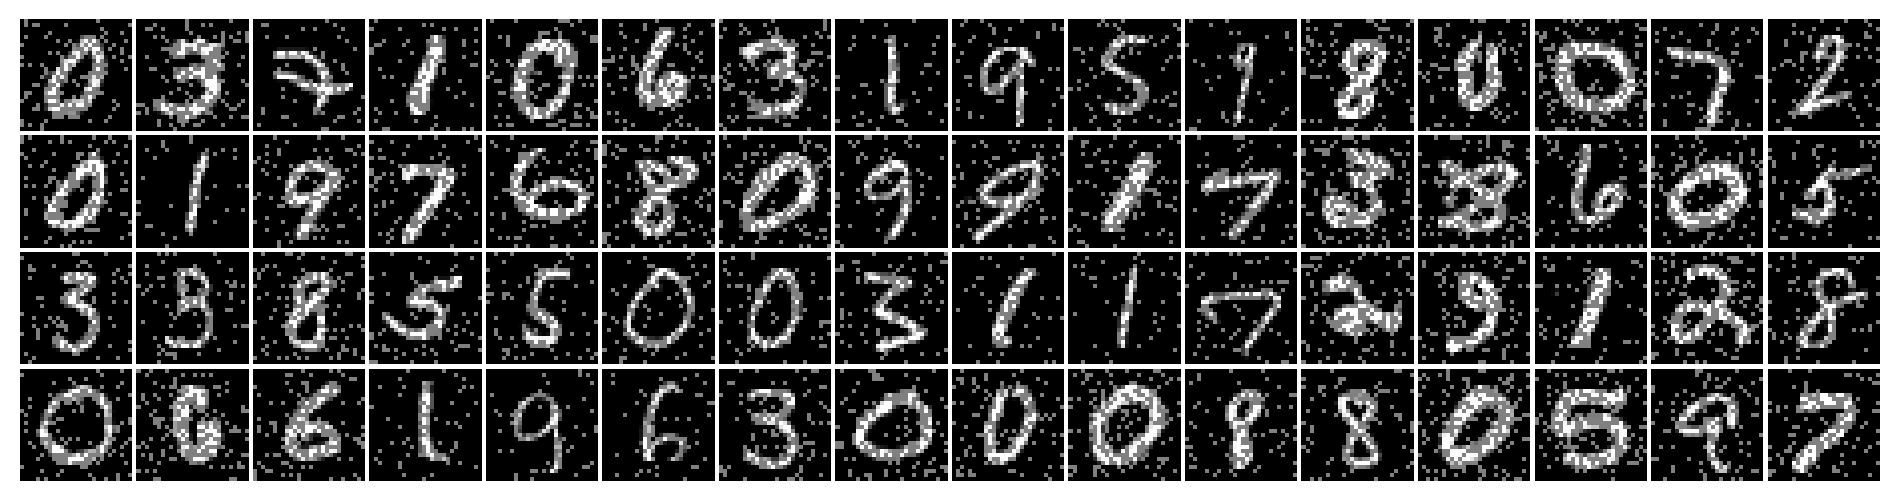

In [14]:
data_samples, mask_samples, _ = next(iter(data_loader))
fig, ax = plt.subplots(figsize=(12, 3))
plot_grid(ax, mask_data(data_samples, mask_samples.float(), .5),
          nrow=4, ncol=16)

## MisGAN

MisGAN is a GAN-based framework for learning distributions in the presence
of incomplete observations. The overall structure is illustrated below:

<center><img src="https://drive.google.com/uc?id=1P7JtHqIFJBFAOb4cnH9dj8zc7UgSY7-4" width="500" /></center>

MisGAN consists of a data generator $G_x$ that generates complete data.
In addition, it also has a mask generator $G_m$ to explicitly model the
missing data process. 
Note that the input $(\mathbf{x}, \mathbf{m})$ is the incomplete data that
follows the representation mentioned earlier.

MisGAN mimics the generation of incomplete data (under the MCAR assumption)
by treating the generated complete data $\tilde{\mathbf{x}}$ together with
the generated mask $\tilde{\mathbf{m}}$ as an incomplete data instance,
with the mask specifies which entries in $\tilde{\mathbf{x}}$ are considered
missing.

We then complete both the real incomplete data $(\mathbf{x}, \mathbf{m})$
and the generated ones $(\tilde{\mathbf{x}}, \tilde{\mathbf{m}})$
using the same masking operator $f_{\tau}$.
We train the data generator $G_x$ by making the masked generated data
$f_{\tau}(\tilde{\mathbf{x}}, \tilde{\mathbf{m}})$ indistinguishable from
the masked real incomplete data $f_{\tau}(\mathbf{x}, \mathbf{m})$ using
a data discriminator $D_x$.

On the other hand, since both generated masks $\tilde{\mathbf{m}}$ and
real masks $\mathbf{m}$ are fully-observed, we can train the mask generator
$G_m$ with a mask discriminator $D_m$ as in a standard GAN.

### Generator

For each generator, we use a linear layer followed by three deconvolution
layers with ReLUs in between.

`ConvDataGenerator` implements the data generator $G_x$.
Since the pixel values are in \[0, 1\], we apply the sigmoid activation to
the real-valued output at the end.

`ConvMaskGenerator` implements the mask generator $G_m$.
Note that the masks are binary-valued.
Since discrete data generating processes have zero gradient almost everywhere,
to carry out gradient-based training for GANs, we relax the output
of the mask generator $G_m$ from $\{0,1\}^n$ to $[0, 1]^n$.
We use the sigmoid activated output $\sigma(z / \lambda)$
with a low temperature $\lambda = 0.66$ to encourage saturation
and make the output closer to zero or one.

In [15]:
# Must sub-class ConvGenerator to provide transform()
class ConvGenerator(nn.Module):
    def __init__(self, latent_size=128):
        super().__init__()

        self.DIM = 64
        self.latent_size = latent_size

        self.preprocess = nn.Sequential(
            nn.Linear(latent_size, 4 * 4 * 4 * self.DIM),
            nn.ReLU(True),
        )
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(4 * self.DIM, 2 * self.DIM, 5),
            nn.ReLU(True),
        )
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(2 * self.DIM, self.DIM, 5),
            nn.ReLU(True),
        )
        self.deconv_out = nn.ConvTranspose2d(self.DIM, 1, 8, stride=2)

    def forward(self, input):
        net = self.preprocess(input)
        net = net.view(-1, 4 * self.DIM, 4, 4)
        net = self.block1(net)
        net = net[:, :, :7, :7]
        net = self.block2(net)
        net = self.deconv_out(net)
        return self.transform(net).view(-1, 1, 28, 28)


class ConvDataGenerator(ConvGenerator):
    def __init__(self, latent_size=128):
        super().__init__(latent_size=latent_size)
        self.transform = lambda x: torch.sigmoid(x)


class ConvMaskGenerator(ConvGenerator):
    def __init__(self, latent_size=128, temperature=.66):
        super().__init__(latent_size=latent_size)
        self.transform = lambda x: torch.sigmoid(x / temperature)

### Discriminator

We implement the discriminator (or referred to as the critic in
Wasserstein GANs) in `ConvCritic` with three convolutional layers followed by
a linear layer for both $D_x$ and $D_m$.

In [16]:
class ConvCritic(nn.Module):
    def __init__(self):
        super().__init__()

        self.DIM = 64
        main = nn.Sequential(
            nn.Conv2d(1, self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(self.DIM, 2 * self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(2 * self.DIM, 4 * self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
        )
        self.main = main
        self.output = nn.Linear(4 * 4 * 4 * self.DIM, 1)

    def forward(self, input):
        input = input.view(-1, 1, 28, 28)
        net = self.main(input)
        net = net.view(-1, 4 * 4 * 4 * self.DIM)
        net = self.output(net)
        return net.view(-1)

### Training Wasserstein GAN with gradient penalty

MisGAN is compatible with many GAN variations, and here we use
[Wasserstein GAN](https://arxiv.org/abs/1701.07875) to train MisGAN.
`CriticUpdater` computes the loss of the discriminator and updates 
its parameters accordingly.
We follow the [WGAN-GP](https://arxiv.org/abs/1704.00028) procedure to
train discriminators with the gradient penalty.

Specifically,
given the data distribution $p_r$ and the model distribution $p_g$,
the loss for the discriminator $D$ is given by

$$
\mathcal{L} =
\mathbb{E}_{\tilde{\mathbf{x}}\sim p_g}\big[D(\tilde{\mathbf{x}})\big] -
\mathbb{E}_{\mathbf{x}\sim p_r}\big[D(\mathbf{x})\big] +
\lambda \mathbb{E}_{\mathbf{y}}
\big[\left(\|\nabla_{\mathbf{y}} D(\mathbf{y})\|_2 - 1\right)^2\big]
$$

where $\mathbf{y}$ is sampled according to
$\mathbf{y}=\xi\mathbf{x} + (1-\xi)\tilde{\mathbf{x}}$ with
$\tilde{\mathbf{x}}\sim p_g$, $\mathbf{x}\sim p_r$,
and $\xi\sim\operatorname{uniform}(0, 1)$.
The gradient penalty term is for enforcing the (soft) 1-Lipschtiz
constraint required by the Wasserstein GAN.

Samples drawn from $p_r$ and $p_g$ are provided as `real` and `fake`
respectively when calling `CriticUpdater`.

In [17]:
class CriticUpdater:
    def __init__(self, critic, critic_optimizer, batch_size=64, gp_lambda=10):
        self.critic = critic
        self.critic_optimizer = critic_optimizer
        self.gp_lambda = gp_lambda
        # Interpolation coefficient
        self.eps = torch.empty(batch_size, 1, 1, 1, device=device)
        # For computing the gradient penalty
        self.ones = torch.ones(batch_size).to(device)

    def __call__(self, real, fake):
        real = real.detach()
        fake = fake.detach()
        self.critic.zero_grad()
        self.eps.uniform_(0, 1)
        interp = (self.eps * real + (1 - self.eps) * fake).requires_grad_()
        grad_d = grad(self.critic(interp), interp, grad_outputs=self.ones,
                      create_graph=True)[0]
        grad_d = grad_d.view(real.shape[0], -1)
        grad_penalty = ((grad_d.norm(dim=1) - 1)**2).mean() * self.gp_lambda
        w_dist = self.critic(fake).mean() - self.critic(real).mean()
        loss = w_dist + grad_penalty
        loss.backward()
        self.critic_optimizer.step()

Now, we instantiate all the building blocks for MisGAN: the data/mask
generators and their corresponding discriminators.
We use the [Adam optimizer](https://arxiv.org/abs/1412.6980) to train them.

In [18]:
nz = 128   # dimensionality of the latent code
n_critic = 5
alpha = .2

data_gen = ConvDataGenerator().to(device)
mask_gen = ConvMaskGenerator().to(device)

data_critic = ConvCritic().to(device)
mask_critic = ConvCritic().to(device)

data_noise = torch.empty(batch_size, nz, device=device)
mask_noise = torch.empty(batch_size, nz, device=device)

lrate = 1e-4
data_gen_optimizer = optim.Adam(
    data_gen.parameters(), lr=lrate, betas=(.5, .9))
mask_gen_optimizer = optim.Adam(
    mask_gen.parameters(), lr=lrate, betas=(.5, .9))

data_critic_optimizer = optim.Adam(
    data_critic.parameters(), lr=lrate, betas=(.5, .9))
mask_critic_optimizer = optim.Adam(
    mask_critic.parameters(), lr=lrate, betas=(.5, .9))

update_data_critic = CriticUpdater(
    data_critic, data_critic_optimizer, batch_size)
update_mask_critic = CriticUpdater(
    mask_critic, mask_critic_optimizer, batch_size)

### Training MisGAN

To describe the training procedure of MisGAN,
we first define the following loss functions,
one for the masks and the other for the data:

$$
\begin{split}
  \mathcal{L}_m(D_m, G_m) &=
  \mathbb{E}_{(\mathbf{x},\mathbf{m})\sim p_\mathcal{D}}\left[D_m(\mathbf{m})\right] -
  \mathbb{E}_{\boldsymbol{\varepsilon}\sim p_\varepsilon}\left[D_m(G_m(\boldsymbol{\varepsilon}))\right],
  \\
  \mathcal{L}_x(D_x, G_x, G_m) &=
  \mathbb{E}_{(\mathbf{x},\mathbf{m})\sim p_\mathcal{D}}\left[D_x(f_\tau(\mathbf{x},\mathbf{m}))\right] -
  \mathbb{E}_{\boldsymbol{\varepsilon}\sim p_\varepsilon, \mathbf{z}\sim p_z}\left[
  D_x\left(f_\tau\left(G_x(\mathbf{z}),G_m(\boldsymbol{\varepsilon})\right)\right)\right].
\end{split}
$$

We optimize the generators and the discriminators
according to the following objectives:

$$
\begin{split}
  &\min_{G_x}\max_{D_x\in\mathcal{F}_x} \mathcal{L}_x(D_x, G_x, G_m),
  \\
  &\min_{G_m}\max_{D_m\in\mathcal{F}_m} \mathcal{L}_m(D_m, G_m) + \alpha \mathcal{L}_x(D_x, G_x, G_m),
\end{split}
$$

where $\mathcal{F}_x, \mathcal{F}_m$ are defined such that $D_x, D_m$ are
both 1-Lipschitz in Wasserstein GANs.
We alternate between `n_critic` steps of optimizing the discriminators
and one step of optimizing the generators.
The update of the discriminator is implemented in `CriticUpdater` described
earlier, which handles the Lipschitz constraint.
We use $\alpha=0.2$ to encourage the generated masks to match the distribution
of the real masks and the masked generated complete samples
to match masked real data.

In the example, 
we use the standard Gaussian $\mathcal{N}(\mathbf{0}, \mathbf{I})$ 
for both noise distributions $p_z$ and $p_\varepsilon$.

During training, we draw a bunch of generated complete data and mask samples
every `plot_interval` epochs to assess the training progress qualitatively.

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0


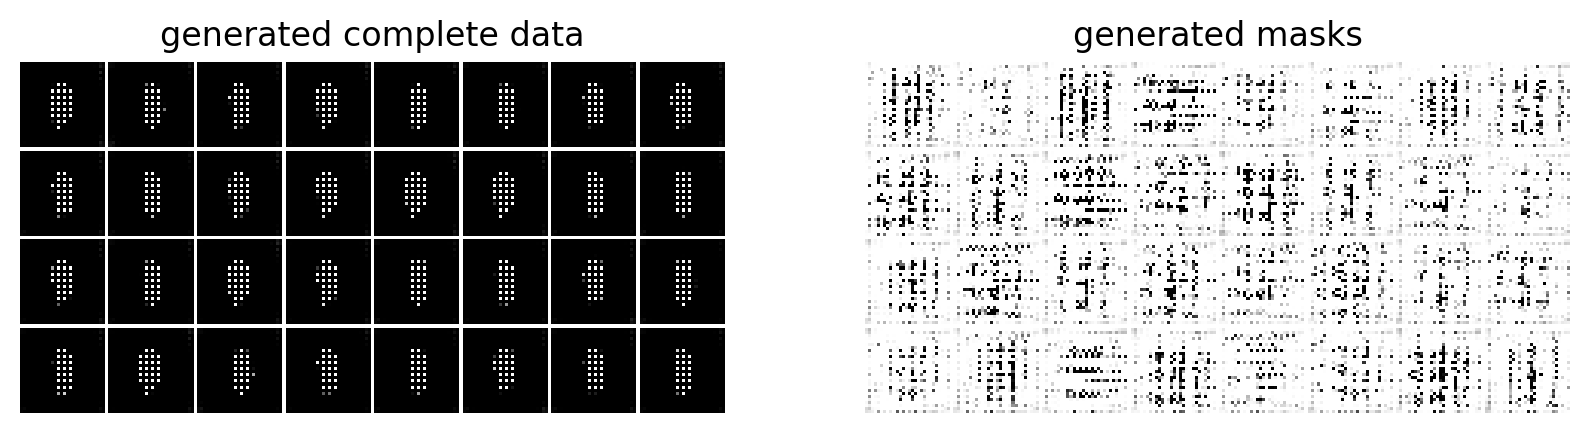

100%|██████████| 1/1 [03:18<00:00, 198.46s/it]


In [24]:
plot_interval = 25
critic_updates = 0

for epoch in tqdm(range(num_epochs)):
    for real_data, real_mask, _ in data_loader:

        real_data = real_data.to(device)
        real_mask = real_mask.to(device).float()

        # Update discriminators' parameters
        data_noise.normal_()
        mask_noise.normal_()

        fake_data = data_gen(data_noise)
        fake_mask = mask_gen(mask_noise)

        masked_fake_data = mask_data(fake_data, fake_mask)
        masked_real_data = mask_data(real_data, real_mask)

        update_data_critic(masked_real_data, masked_fake_data)
        update_mask_critic(real_mask, fake_mask)

        critic_updates += 1

        if critic_updates == n_critic:
            critic_updates = 0

            # Update generators' parameters
            for p in data_critic.parameters():
                p.requires_grad_(False)
            for p in mask_critic.parameters():
                p.requires_grad_(False)

            data_noise.normal_()
            mask_noise.normal_()

            fake_data = data_gen(data_noise)
            fake_mask = mask_gen(mask_noise)
            masked_fake_data = mask_data(fake_data, fake_mask)

            data_loss = -data_critic(masked_fake_data).mean()
            data_gen.zero_grad()
            data_loss.backward(retain_graph=True)
            data_gen_optimizer.step()

            data_noise.normal_()
            mask_noise.normal_()

            fake_data = data_gen(data_noise)
            fake_mask = mask_gen(mask_noise)
            masked_fake_data = mask_data(fake_data, fake_mask)

            data_loss = -data_critic(masked_fake_data).mean()
            mask_loss = -mask_critic(fake_mask).mean()
            mask_gen.zero_grad()
            (mask_loss + data_loss * alpha).backward()
            mask_gen_optimizer.step()

            for p in data_critic.parameters():
                p.requires_grad_(True)
            for p in mask_critic.parameters():
                p.requires_grad_(True)

    if plot_interval > 0 and (epoch + 1) % plot_interval == 0:
        # Although it makes no difference setting eval() in this example, 
        # you will need those if you are going to use modules such as 
        # batch normalization or dropout in the generators.
        data_gen.eval()
        mask_gen.eval()

        with torch.no_grad():
            print('Epoch:', epoch)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
            
            data_noise.normal_()
            data_samples = data_gen(data_noise)
            plot_grid(ax1, data_samples, title='generated complete data')
            
            mask_noise.normal_()
            mask_samples = mask_gen(mask_noise)
            plot_grid(ax2, mask_samples, title='generated masks')
            
            plt.show()
            plt.close(fig)

        data_gen.train()
        mask_gen.train()
    
    if save_interval > 0 and (epoch + 1) % save_interval == 0:
        torch.save({
                'epoch': epoch,
                'model_state_dict': data_gen.state_dict(),
                'optimizer_state_dict': data_gen_optimizer.state_dict(),
                'loss': data_loss,
                }, model_dir + 'data_gen_epoch-{}.pth'.format(epoch))
        torch.save({
                'epoch': epoch,
                'model_state_dict': mask_gen.state_dict(),
                'optimizer_state_dict': mask_gen_optimizer.state_dict(),
                'loss': mask_loss,
                }, model_dir + 'mask_gen_epoch-{}.pth'.format(epoch))

## Loading a trained MisGAN model
Loading a model which was trained in the cell above

In [26]:
checkpoint_num = 9
checkpoint = torch.load(model_dir + 'data_gen_epoch-{}.pth'.format(checkpoint_num))
data_gen.load_state_dict(checkpoint['model_state_dict'])
data_gen.eval()

ConvDataGenerator(
  (preprocess): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
  )
  (block1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (deconv_out): ConvTranspose2d(64, 1, kernel_size=(8, 8), stride=(2, 2))
)

## Missing data imputation

Now, we introduce an extension of MisGAN for missing data imputation.
The goal of missing data imputation is to complete the
missing data according to $p(\mathbf{x}_\text{mis}|\mathbf{x}_\text{obs})$.
To do so, we augment MisGAN with an imputer $G_i$ accompanied by
a corresponding discriminator $D_i$ as illustrated below.

<center><img src="https://drive.google.com/uc?id=1QL49WzxRnB4JNToinyn4BCiqb5Gxs36C" width="600" /></center>

The imputer $G_m$ is a function of the incomplete example
$(\mathbf{x},\mathbf{m})$ and a random vector $\boldsymbol{\omega}$
drawn from a noise distribution $p_\omega$.
The noise $\boldsymbol{\omega}$ is for modeling the uncertainty when sampling
from $p(\mathbf{x}_\text{mis}|\mathbf{x}_\text{obs})$.
The imputer is trained by making the completed data $\hat{\mathbf{x}}$
indistinguishable from the generated complete data $\tilde{\mathbf{x}}$.

### Imputer

We construct the imputer $G_i(\mathbf{x},\mathbf{m},\boldsymbol{\omega})$
as the follows:

$$
G_i(\mathbf{x},\mathbf{m},\boldsymbol{\omega})
=\mathbf{x}\odot\mathbf{m}+\hat{G}_i(\mathbf{x}\odot\mathbf{m} + \boldsymbol{\omega}\odot\bar{\mathbf{m}})\odot\bar{\mathbf{m}}.
$$

where $\hat{G}_i$ is a imputer network that generates the imputation result.

The masking on the input of the imputer network,
$\mathbf{x}\odot\mathbf{m} + \boldsymbol{\omega}\odot\bar{\mathbf{m}}$,
ensures that the amount of noise injected to $\hat{G}_i$
is complementary to the size of the observed features.
This is intuitive in the sense that when a data case is almost fully-observed,
we expect less variety in $p(\mathbf{x}_\text{mis}|\mathbf{x}_\text{obs})$
and vice versa.
Note that the noise $\boldsymbol{\omega}$ needs to have the same dimensionality
as $\mathbf{x}$.

The final masking (outside of $\hat{G}_i$)
ensures that the observed entries of $\mathbf{x}$ are kept
intact in the output of the imputer $G_i$.

We implement $G_i$ in `Imputer` as a three-layer fully-connected network
with ReLUs in between.

In [27]:
class Imputer(nn.Module):
    def __init__(self, arch=(512, 512)):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(784, arch[0]),
            nn.ReLU(),
            nn.Linear(arch[0], arch[1]),
            nn.ReLU(),
            nn.Linear(arch[1], arch[0]),
            nn.ReLU(),
            nn.Linear(arch[0], 784),
        )

    def forward(self, data, mask, noise):
        net = data * mask + noise * (1 - mask)
        net = net.view(data.shape[0], -1)
        net = self.fc(net)
        net = torch.sigmoid(net).view(data.shape)
        return data * mask + net * (1 - mask)

Now we instantiate the imputer and the corresponding discriminator.
We also use the Adam optimizer to train them.
Note that for MisGAN imputation, we will re-use most of the components
created earlier for MisGAN including the data/mask generators and
the discriminators.

In [28]:
imputer = Imputer().to(device)
impu_critic = ConvCritic().to(device)
impu_noise = torch.empty(batch_size, 1, 28, 28, device=device)

imputer_lrate = 2e-4
imputer_optimizer = optim.Adam(
    imputer.parameters(), lr=imputer_lrate, betas=(.5, .9))
impu_critic_optimizer = optim.Adam(
    impu_critic.parameters(), lr=imputer_lrate, betas=(.5, .9))
update_impu_critic = CriticUpdater(
    impu_critic, impu_critic_optimizer, batch_size)

### Training MisGAN imputer

To train the imputer-equipped MisGAN,
we define the following losses (MisGAN uses the first two):

$$
\begin{split}
  \mathcal{L}_m(D_m, G_m) &=
  \mathbb{E}_{(\mathbf{x},\mathbf{m})\sim p_\mathcal{D}}\left[D_m(\mathbf{m})\right] -
  \mathbb{E}_{\boldsymbol{\varepsilon}\sim p_\varepsilon}\left[D_m(G_m(\boldsymbol{\varepsilon}))\right],
  \\
  \mathcal{L}_x(D_x, G_x, G_m) &=
  \mathbb{E}_{(\mathbf{x},\mathbf{m})\sim p_\mathcal{D}}\left[D_x(f_\tau(\mathbf{x},\mathbf{m}))\right] -
  \mathbb{E}_{\boldsymbol{\varepsilon}\sim p_\varepsilon, \mathbf{z}\sim p_z}\left[
  D_x\left(f_\tau\left(G_x(\mathbf{z}),G_m(\boldsymbol{\varepsilon})\right)\right)\right],
  \\
  \mathcal{L}_i(D_i, G_i, G_x) &=
  \mathbb{E}_{\mathbf{z}\sim p_z}\left[D_i(G_x(\mathbf{z}))\right] -
  \mathbb{E}_{(\mathbf{x},\mathbf{m})\sim p_\mathcal{D}, \boldsymbol{\omega}\sim p_\omega}
  \left[D_i(G_i(\mathbf{x},\mathbf{m},\boldsymbol{\omega}))\right].
\end{split}
$$

We jointly learn the data generating process and
the imputer according to the following objectives:

$$
\begin{split}
\min_{G_i}\max_{D_i\in\mathcal{F}_i}\ &\mathcal{L}_i(D_i, G_i, G_x),
\label{eq:objimputer}\\
\min_{G_x}\max_{D_x\in\mathcal{F}_x}\ &\mathcal{L}_x(D_x, G_x, G_m) + \beta \mathcal{L}_i(D_i, G_i, G_x),
\\
\min_{G_m}\max_{D_m\in\mathcal{F}_m}\ &\mathcal{L}_m(D_m, G_m) + \alpha \mathcal{L}_x(D_x, G_x, G_m),
\end{split}
$$

where we use $\beta=0.1$ to encourage the generated complete data to match
the distribution of the imputed real data in addition to
having the masked generated data to match the masked real data.

In the MNIST example, the noise for the imputer $\boldsymbol{\omega}$
(`impu_noise`) is drawn from $p_\omega=\operatorname{uniform}(0, 1)$
to match the range of the pixel value \[0, 1\].

We plot the imputation results every `plot_interval` epochs.
In each of the plots,
the region inside of each red box are the observed pixels;
the pixels outside of the box are generated by the imputer.

In [29]:
beta = .1
plot_interval = 25
critic_updates = 0

for epoch in tqdm(range(num_epochs_imputer)):
    for real_data, real_mask, index in data_loader:

        real_data = real_data.to(device)
        real_mask = real_mask.to(device).float()

        masked_real_data = mask_data(real_data, real_mask)

        # Update discriminators' parameters
        data_noise.normal_()
        fake_data = data_gen(data_noise)

        mask_noise.normal_()
        fake_mask = mask_gen(mask_noise)
        masked_fake_data = mask_data(fake_data, fake_mask)

        impu_noise.uniform_()
        imputed_data = imputer(real_data, real_mask, impu_noise)

        update_data_critic(masked_real_data, masked_fake_data)
        update_mask_critic(real_mask, fake_mask)
        update_impu_critic(fake_data, imputed_data)

        critic_updates += 1

        if critic_updates == n_critic:
            critic_updates = 0

            # Update generators' parameters
            for p in data_critic.parameters():
                p.requires_grad_(False)
            for p in mask_critic.parameters():
                p.requires_grad_(False)
            for p in impu_critic.parameters():
                p.requires_grad_(False)

            impu_noise.uniform_()
            imputed_data = imputer(real_data, real_mask, impu_noise)
            impu_loss = -impu_critic(imputed_data).mean()

            data_noise.normal_()
            fake_data = data_gen(data_noise)

            mask_noise.normal_()
            fake_mask = mask_gen(mask_noise)
            masked_fake_data = mask_data(fake_data, fake_mask)

            data_loss = -data_critic(masked_fake_data).mean()
            mask_loss = -mask_critic(fake_mask).mean()
            
            mask_gen.zero_grad()
            (mask_loss + data_loss * alpha).backward(retain_graph=True)
            mask_gen_optimizer.step()

            data_noise.normal_()
            fake_data = data_gen(data_noise)

            mask_noise.normal_()
            fake_mask = mask_gen(mask_noise)
            masked_fake_data = mask_data(fake_data, fake_mask)

            data_loss = -data_critic(masked_fake_data).mean()

            data_gen.zero_grad()
            (data_loss + impu_loss * beta).backward(retain_graph=True)
            data_gen_optimizer.step()

            imputer.zero_grad()
            impu_loss.backward()
            imputer_optimizer.step()

            for p in data_critic.parameters():
                p.requires_grad_(True)
            for p in mask_critic.parameters():
                p.requires_grad_(True)
            for p in impu_critic.parameters():
                p.requires_grad_(True)
    
    if save_interval_imputer > 0 and (epoch + 1) % save_interval_imputer == 0:
        torch.save({
                'epoch': epoch,
                'model_state_dict': imputer.state_dict(),
                'optimizer_state_dict': imputer_optimizer.state_dict(),
                'loss': data_loss,
                }, model_dir + 'imputer_epoch-{}.pth'.format(epoch))
#         torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': mask_gen.state_dict(),
#                 'optimizer_state_dict': mask_gen_optimizer.state_dict(),
#                 'loss': mask_loss,
#                 }, model_dir + 'mask_gen_epoch-{}.pth'.format(epoch))
    
    if plot_interval > 0 and (epoch + 1) % plot_interval == 0:
        with torch.no_grad():
            imputer.eval()

            # Plot imputation results
            impu_noise.uniform_()
            imputed_data = imputer(real_data, real_mask, impu_noise)
            #bbox = [data.mask_loc[idx] for idx in index]
            bbox = None
            print('Epoch:', epoch)
            fig, ax = plt.subplots(figsize=(6, 3))
            plot_grid(ax, imputed_data, bbox, gap=2)
            plot_grid(ax, imputed_data, bbox, gap=2)
            plt.show()
            plt.close(fig)

            imputer.train()

100%|██████████| 1/1 [04:34<00:00, 274.48s/it]


# Loading imputer

In [31]:
checkpoint_num = 9
imputer = Imputer().to(device)
checkpoint = torch.load(model_dir + 'imputer_epoch-{}.pth'.format(checkpoint_num))
imputer.load_state_dict(checkpoint['model_state_dict'])

#imputer.cuda()

<All keys matched successfully>

In [33]:
import numpy
from numpy.random import random
import scipy
from scipy import linalg
from numpy import iscomplexobj
from numpy import trace
# calculate frechet inception distance
def calculate_fid(act1, act2):
# calculate mean and covariance statistics
    mu1, sigma1 = numpy.array(act1.mean(axis=0)), numpy.cov(act1, rowvar=False)
    mu2, sigma2 = numpy.array(act2.mean(axis=0)), numpy.cov(act2, rowvar=False)
    # calculate sum squared difference between mean
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid
fid = []
for i in range(len(real_data)):
    fid.append(calculate_fid(real_data[i].cpu().reshape(28,28), imputed_data[i].cpu().reshape(28,28)))

In [38]:
fid = []
for real_data, real_mask, index in data_loader:
    with torch.no_grad():
        imputer.eval()
        impu_noise = torch.empty(batch_size, 1, 28, 28, device=device)
        impu_noise.uniform_()
        real_data = real_data.to(device)
        real_mask = real_mask.to(device).float()
        imputer = imputer.to(device)
        imputed_data = imputer(real_data, real_mask, impu_noise)
        for i in range(len(real_data)):
            fid.append(calculate_fid(real_data[i].cpu().reshape(28,28), imputed_data[i].cpu().reshape(28,28)))
fid_array = np.array(fid)[~np.isnan(np.array(fid))]
np.mean(fid_array)

Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.


0.11783411958681066

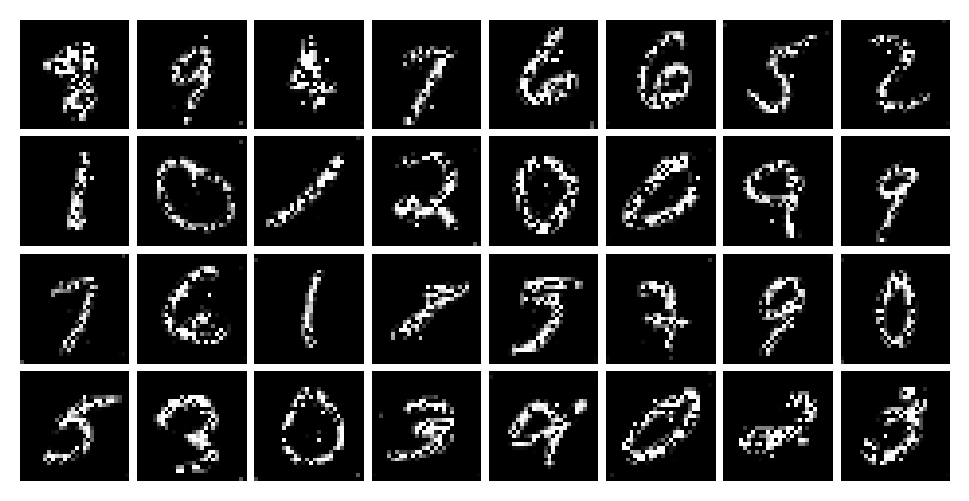

In [37]:
bbox=None
fig, ax = plt.subplots(figsize=(6, 3))
plot_grid(ax, imputed_data, bbox, gap=2)

In [42]:
import pickle as p

try:
    with open("fid_dict.p", "rb") as f:
        fid_dict = p.load(f)

except:
    fid_dict = {}

fid_dict[missing_type] = fid_array

with open("fid_dict.p", "wb") as f:
    p.dump(fid_dict, f)

To open run the following code:

In [49]:
# To open result dict use the following code:
with open("fid_dict.p", "rb") as f:
    fid_dict = p.load(f)

fid_dict.keys()

dict_keys(['MNAR_bernoulli_0.15_scale_0.2'])